# Prediction

This code is designed to allow you to easily generate a heatmap for a cancer slides. You must first add this folder, named train_data, to your Google Drive:

https://drive.google.com/open?id=1Dw8OYwJWokRlqo9CJs_yql9K6Ev7lmu4

## Importing Necessary Packages

In [0]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from google.colab import drive

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/slides/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Utility Functions

In [0]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

## Generate a Level 4 Heatmap on a Slide

In [0]:
!cp /gdrive/My\ Drive/train_data/level_4/model.h5 /content/level4_model.h5
!cp /gdrive/My\ Drive/train_data/level_2/model.h5 /content/level2_model.h5

In [0]:
# Global Variables
LEVEL_4_MODEL = tf.keras.models.load_model('/content/level4_model.h5')
LEVEL_2_MODEL = tf.keras.models.load_model('/content/level2_model.h5')

In [0]:
incept = tf.keras.applications.InceptionV3(input_shape=(500,500,3),
                                           include_top=False,
                                           pooling='max',
                                           weights='imagenet')

In [0]:
slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

if not os.path.exists(slide_path):
  !curl -O $slide_url

if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url


In [0]:
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

x_range, y_range = slide.level_dimensions[4]
pred_mask = np.zeros((y_range,x_range))

img = read_slide(slide, x=0, y=0, level=4, width=x_range, height=y_range)
mask = read_slide(tumor_mask, x=0, y=0, level=4, width=x_range, height=y_range)

mask = mask[:,:,0]

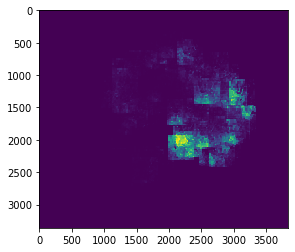

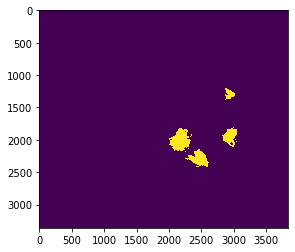

In [0]:
from random import randint

predictions = 0 
while predictions < 100:
  x, y = randint(0, x_range-500), randint(0, y_range-500)
  new_img = img[y:y+500, x:x+500]
  tissue_pixels = list(find_tissue_pixels(new_img))
  percent_tissue = len(tissue_pixels) / float(new_img.shape[0] * new_img.shape[0]) * 100

  if percent_tissue > 50.0:
    predictions += 1
    activations = tf.keras.applications.inception_v3.preprocess_input(new_img)
    rep = incept.predict(np.array([activations]))
    pred_heatmap = LEVEL_4_MODEL.predict(rep).reshape(400,400)
    pred_mask[y:y+400, x:x+400] = 0.5*pred_mask[y:y+400, x:x+400] + 0.5*pred_heatmap 

plt.imshow(pred_mask)
plt.show()

plt.imshow(mask)
plt.show()

## Level-2 Heatmap Corrections

In [0]:
import numpy as np

x = np.array([np.sum(pred_mask[:,i]) for i in range(pred_mask.shape[1])])
y = np.array([np.sum(pred_mask[i,:]) for i in range(pred_mask.shape[0])])

In [0]:
def index_stats(x):
  probs_x = x/np.sum(x)
  x_mean = 0
  for i in range(len(x)):
    x_mean += (probs_x[i]*i)
  x_var = 0
  for i in range(len(x)):
    x_var += (probs_x[i]*pow(i,2))
  x_var -= pow(x_mean,2)
  return x_mean, pow(x_var,0.5)

x_mu, x_sd = index_stats(x)
y_mu, y_sd = index_stats(y)

In [0]:
x_samp = np.array([np.random.normal(x_mu, x_sd, size=500)])
y_samp = np.array([np.random.normal(y_mu, y_sd, size=500)])
integerize = np.vectorize(int)
samp = np.append(x_samp-200,y_samp-200, axis=0).T
samp = integerize(samp)

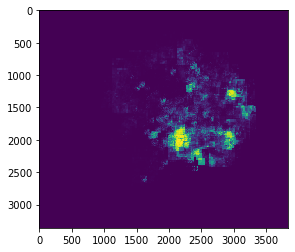

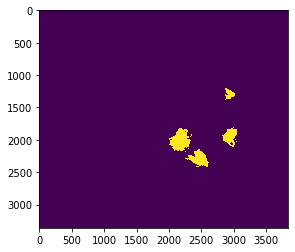

In [0]:
from random import randint
import cv2 

incept_level_2 = tf.keras.applications.InceptionV3(input_shape=(400,400,3),
                                           include_top=False,
                                           pooling='max',
                                           weights='imagenet')
for x, y in samp:
  new_img = read_slide(slide, x=x*pow(2,4), y=y*pow(2,4), level=2, width=400, height=400)
  tissue_pixels = list(find_tissue_pixels(new_img))
  percent_tissue = len(tissue_pixels) / float(new_img.shape[0] * new_img.shape[0]) * 100

  if percent_tissue > 25.0:
    activations = tf.keras.applications.inception_v3.preprocess_input(new_img)
    rep = incept_level_2.predict(np.array([activations]))
    pred_heatmap = LEVEL_2_MODEL.predict(rep).reshape(400,400)
    pred_heatmap = cv2.resize(pred_heatmap, dsize=(100,100))
    pred_mask[y:y+100, x:x+100] = 0.5*pred_mask[y:y+100, x:x+100] + 0.5*pred_heatmap 

plt.imshow(pred_mask)
plt.show()

plt.imshow(mask)
plt.show()